## Import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# загружаем данные train

DATA_PATH = "../data/"

train_transaction = pd.read_csv(DATA_PATH + "train_transaction.csv")
train_identity = pd.read_csv(DATA_PATH + "train_identity.csv")

print("Transaction shape:", train_transaction.shape)
print("Identity shape:", train_identity.shape)

train_transaction.head()

Transaction shape: (590540, 394)
Identity shape: (144233, 41)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# объединяем таблицы
train = train_transaction.merge(train_identity, on="TransactionID", how="left")

print("Merged shape:", train.shape)
train.head()

Merged shape: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## EDA

In [7]:
#Проверяем целевую переменную (fraud)
train["isFraud"].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

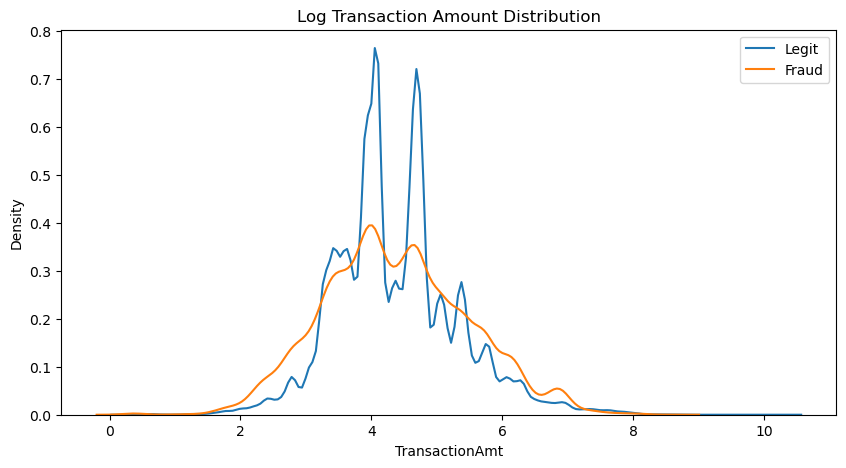

In [14]:
# np.log1p(
# np.log1p() = логарифм сжимает большие значения, делает распределение более нормальным и график становится читаемым

plt.figure(figsize=(10,5))
sns.kdeplot(np.log1p(train.loc[train.isFraud==0, "TransactionAmt"]), label="Legit")
sns.kdeplot(np.log1p(train.loc[train.isFraud==1, "TransactionAmt"]), label="Fraud")
plt.title("Log Transaction Amount Distribution")
plt.legend()
plt.show()

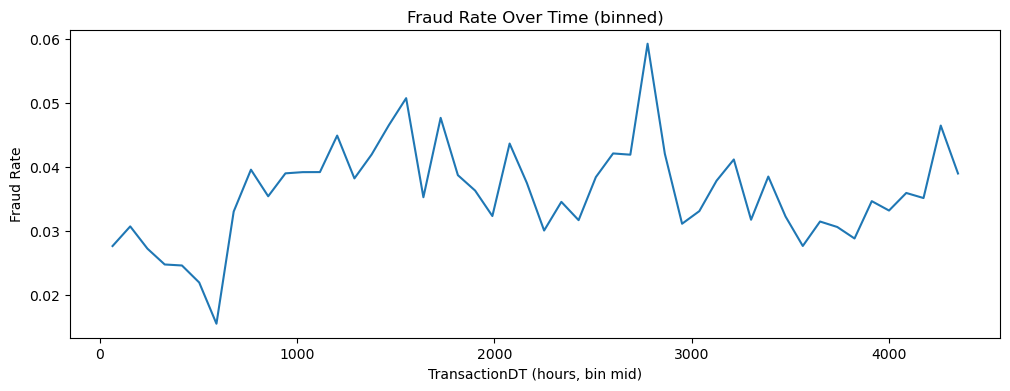

In [18]:
train["TransactionDT_hours"] = train["TransactionDT"] / 3600

bins = pd.cut(train["TransactionDT_hours"], 50)
s = train.groupby(bins, observed=True)["isFraud"].mean()

x = [interval.mid for interval in s.index]
plt.figure(figsize=(12,4))
plt.plot(x, s.values)
plt.title("Fraud Rate Over Time (binned)")
plt.xlabel("TransactionDT (hours, bin mid)")
plt.ylabel("Fraud Rate")
plt.show()

<Figure size 1200x500 with 0 Axes>

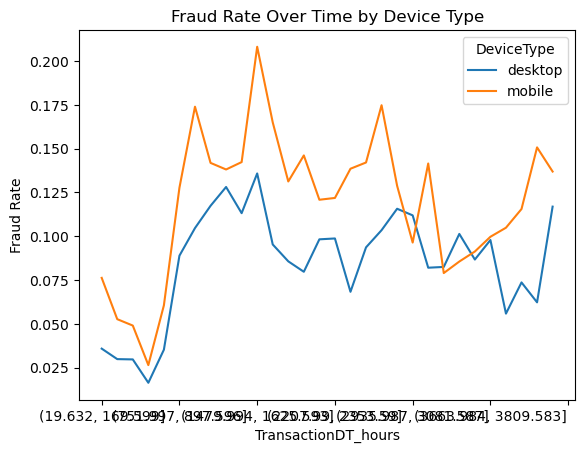

In [20]:
bins = pd.cut(train["TransactionDT_hours"], 30)

fraud_by_device_time = (
    train.groupby([bins, "DeviceType"], observed=True)["isFraud"]
    .mean()
    .unstack()
)

plt.figure(figsize=(12,5))
fraud_by_device_time.plot()
plt.title("Fraud Rate Over Time by Device Type")
plt.ylabel("Fraud Rate")
plt.show()

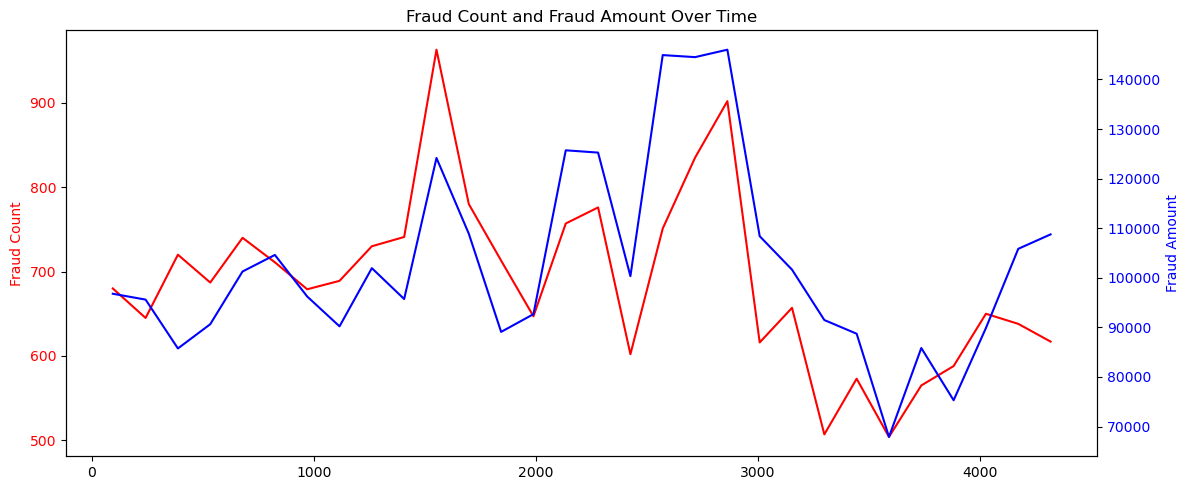

In [22]:
bins = pd.cut(train["TransactionDT_hours"], 30)

fraud_time_stats = train.groupby(bins, observed=True).agg(
    fraud_count=("isFraud", "sum"),
    fraud_amount=("TransactionAmt", lambda x: x[train.loc[x.index, "isFraud"] == 1].sum())
)

# Центры интервалов для оси X
x_vals = [interval.mid for interval in fraud_time_stats.index]

fig, ax1 = plt.subplots(figsize=(12,5))

# Левая ось — количество fraud
ax1.plot(x_vals, fraud_time_stats["fraud_count"], label="Fraud Count", color="red")
ax1.set_ylabel("Fraud Count", color="red")
ax1.tick_params(axis='y', labelcolor='red')

# Правая ось — сумма fraud
ax2 = ax1.twinx()
ax2.plot(x_vals, fraud_time_stats["fraud_amount"], label="Fraud Amount", color="blue")
ax2.set_ylabel("Fraud Amount", color="blue")
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Fraud Count and Fraud Amount Over Time")
fig.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

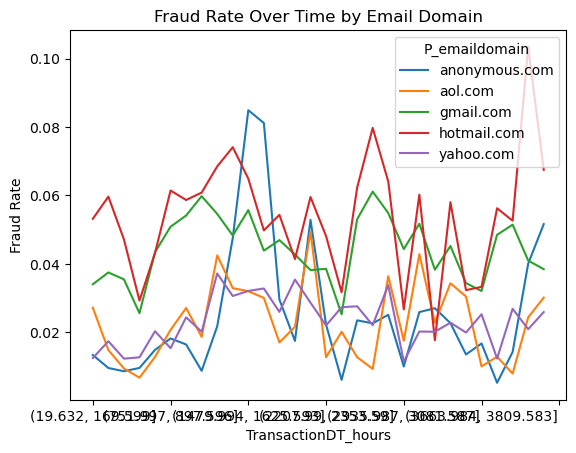

In [24]:
top_domains = train["P_emaildomain"].value_counts().head(5).index

fraud_by_email_time = (
    train[train["P_emaildomain"].isin(top_domains)]
    .groupby([bins, "P_emaildomain"], observed=True)["isFraud"]
    .mean()
    .unstack()
)

plt.figure(figsize=(12,5))
fraud_by_email_time.plot()
plt.title("Fraud Rate Over Time by Email Domain")
plt.ylabel("Fraud Rate")
plt.show()

## Features

In [37]:
# Сделать номер дня транзакции
start_date = pd.to_datetime("2026-01-01")
train["datetime"] = start_date + pd.to_timedelta(train["TransactionDT"], unit="s")

In [47]:
# добавляем номер дня

#train["datetime"].dt.floor("D")
train["day"] = (train["TransactionDT"] // (24*3600)).astype(int)

### Текущий день

In [53]:
train = train.sort_values(["card1", "datetime"])

train["tx_today_before"] = (
    train.groupby(["card1", "day"])
    .cumcount()
)

In [75]:
train = train.sort_values(["card1", "day", "datetime"]).copy()

train["amt_today_before"] = (
    train.groupby(["card1", "day"])["TransactionAmt"]
    .transform(lambda s: s.cumsum().shift(1))
    .fillna(0)
)

### Транзакции за последние 7 / 30 / 90 дней (ДО текущего дня)

In [111]:
# создаем новый df из train, гду группируем по Номеру карты и Дню, таким образоим считаем кол-во трн в дне
train["day_date"] = train["datetime"].dt.floor("D")

daily_tx = (
    train.groupby(["card1", "day_date"], as_index=False)
    .agg(tx_per_day=("TransactionID", "count"))
    .sort_values(["card1", "day_date"])
)

In [115]:
idx = (
    daily_tx.groupby("card1")["day_date"]
    .apply(lambda s: pd.date_range(s.min(), s.max(), freq="D"))
    .explode()
    .reset_index(name="day_date")
)

In [117]:
daily_tx_full = (
    idx.merge(daily_tx, on=["card1", "day_date"], how="left")
    .fillna({"tx_per_day": 0})
    .sort_values(["card1", "day_date"])
)

In [145]:
daily_tx_full = daily_tx_full.sort_values(["card1", "day_date"]).copy()

daily_tx_full["tx_7d_prev"] = (
    daily_tx_full.groupby("card1")["tx_per_day"]
    .transform(lambda s: s.rolling(7, min_periods=1).sum().shift(1))
)

daily_tx_full["tx_30d_prev"] = (
    daily_tx_full.groupby("card1")["tx_per_day"]
    .transform(lambda s: s.rolling(30, min_periods=1).sum().shift(1))
)

daily_tx_full["tx_90d_prev"] = (
    daily_tx_full.groupby("card1")["tx_per_day"]
    .transform(lambda s: s.rolling(90, min_periods=1).sum().shift(1))
)

In [147]:
daily_tx_full[["tx_7d_prev","tx_30d_prev","tx_90d_prev"]] = (
    daily_tx_full[["tx_7d_prev","tx_30d_prev","tx_90d_prev"]].fillna(0)
)

In [149]:
daily_tx_full[daily_tx_full["card1"] == 1027].sort_values(["day_date"]).head(20)

,card1,day_date,tx_per_day,tx_7d,tx_30d,tx_90d,tx_7d_prev,tx_30d_prev,tx_90d_prev
1433,1027,2026-01-13,5.0,5.0,5.0,5.0,0.0,0.0,0.0
1434,1027,2026-01-14,1.0,6.0,6.0,6.0,5.0,5.0,5.0
1435,1027,2026-01-15,0.0,6.0,6.0,6.0,6.0,6.0,6.0
1436,1027,2026-01-16,0.0,6.0,6.0,6.0,6.0,6.0,6.0
1437,1027,2026-01-17,0.0,6.0,6.0,6.0,6.0,6.0,6.0
1438,1027,2026-01-18,0.0,6.0,6.0,6.0,6.0,6.0,6.0
1439,1027,2026-01-19,0.0,6.0,6.0,6.0,6.0,6.0,6.0
1440,1027,2026-01-20,0.0,1.0,6.0,6.0,6.0,6.0,6.0
1441,1027,2026-01-21,0.0,0.0,6.0,6.0,1.0,6.0,6.0
1442,1027,2026-01-22,0.0,0.0,6.0,6.0,0.0,6.0,6.0


In [151]:
train = train.merge(
    daily_tx_full[["card1", "day_date", "tx_7d_prev", "tx_30d_prev", "tx_90d_prev"]],
    on=["card1", "day_date"],
    how="left"
)

### Сумма за последние 7 / 30 / 90 дней (ДО текущего дня)

In [161]:
daily_amt = (
    train.groupby(["card1", "day_date"], as_index=False)
    .agg(amt_per_day=("TransactionAmt", "sum"))
    .sort_values(["card1", "day_date"])
)

In [165]:
idx_amt = (
    daily_amt.groupby("card1")["day_date"]
    .apply(lambda s: pd.date_range(s.min(), s.max(), freq="D"))
    .explode()
    .reset_index(name="day_date")
)

daily_amt_full = (
    idx_amt.merge(daily_amt, on=["card1", "day_date"], how="left")
    .fillna({"amt_per_day": 0})
    .sort_values(["card1", "day_date"])
)

In [167]:
daily_amt_full["amt_7d_prev"] = (daily_amt_full.groupby("card1")["amt_per_day"].transform(lambda s: s.rolling(7, min_periods=1).sum().shift(1)))
daily_amt_full["amt_30d_prev"] = (daily_amt_full.groupby("card1")["amt_per_day"].transform(lambda s: s.rolling(30, min_periods=1).sum().shift(1)))
daily_amt_full["amt_90d_prev"] = (daily_amt_full.groupby("card1")["amt_per_day"].transform(lambda s: s.rolling(90, min_periods=1).sum().shift(1)))
daily_amt_full[["amt_7d_prev","amt_30d_prev","amt_90d_prev"]] = (daily_amt_full[["amt_7d_prev","amt_30d_prev","amt_90d_prev"]].fillna(0))

In [169]:
train = train.merge(
    daily_amt_full[["card1", "day_date", "amt_7d_prev", "amt_30d_prev", "amt_90d_prev"]],
    on=["card1", "day_date"],
    how="left"
)

In [171]:
train[["TransactionAmt","amt_today_before","amt_7d_prev","amt_30d_prev","amt_90d_prev"]].head(10)
train[["amt_7d_prev","amt_30d_prev","amt_90d_prev"]].describe()

,amt_7d_prev,amt_30d_prev,amt_90d_prev
count,590540.000000,590540.000000,590540.000000
mean,13349.527379,48701.874040,116023.913712
std,22735.493511,75651.886344,193810.398628
min,0.000000,0.000000,0.000000
25%,477.600000,1957.950000,3981.270000
50%,3705.395000,13920.270000,29282.680000
75%,14901.385000,57006.763000,125655.371000
max,180449.390000,459665.978000,907655.304000


### Shares and Ratios

share = (A+1) / (A+B+1)

доля сегодняшней активности в недавнем периоде

признак более стабильный и ограниченный [0,1]  

In [189]:
train["tx_today_share_7d"]  = (train["tx_today_before"] + 1) / (train["tx_7d_prev"]  + train["tx_today_before"] + 1)
train["tx_today_share_30d"] = (train["tx_today_before"] + 1) / (train["tx_30d_prev"] + train["tx_today_before"] + 1)
train["tx_today_share_90d"] = (train["tx_today_before"] + 1) / (train["tx_90d_prev"] + train["tx_today_before"] + 1)

In [215]:
today_inc = train["amt_today_before"] + train["TransactionAmt"]

train["amt_today_share_7d"]  = today_inc / (today_inc + train["amt_7d_prev"])
train["amt_today_share_30d"] = today_inc / (today_inc + train["amt_30d_prev"])
train["amt_today_share_90d"] = today_inc / (today_inc + train["amt_90d_prev"])

ratio = A / (B + 1)

во сколько раз сегодня больше обычного

ловит аномальный всплеск относительно обычного поведения


In [217]:
train["tx_today_ratio_7d"]  = (train["tx_today_before"] + 1) / train["tx_7d_prev"]
train["tx_today_ratio_30d"] = (train["tx_today_before"] + 1) / train["tx_30d_prev"]
train["tx_today_ratio_90d"] = (train["tx_today_before"] + 1) / train["tx_90d_prev"]

In [201]:
CAP = 50.0          # верхняя граница, чтобы не было огромного разброса
SCALE = 5.0         # насколько быстро растёт "штраф" по сумме при den=0

def capped_amt_ratio(num, den, cap=CAP, scale=SCALE):
    out = np.zeros(len(num), dtype=float)

    # обычный ratio там, где den > 0
    m = den > 0
    out[m] = (num[m] / den[m])
    out[m] = np.minimum(out[m], cap)

    # если истории нет (den==0), но сумма > 0 -> "умный большой сигнал"
    z = (den == 0) & (num > 0)
    out[z] = np.minimum(cap, np.log1p(num[z]) * scale)

    return out

# 7d
den7 = (train["amt_7d_prev"] + train["amt_today_before"]).values
num = train["TransactionAmt"].values
train["amt_ratio_7d"] = capped_amt_ratio(num, den7)

# 30d
den30 = (train["amt_30d_prev"] + train["amt_today_before"]).values
train["amt_ratio_30d"] = capped_amt_ratio(num, den30)

# 90d
den90 = (train["amt_90d_prev"] + train["amt_today_before"]).values
train["amt_ratio_90d"] = capped_amt_ratio(num, den90)

### avg check

In [226]:
train["avg_amt_30d"] = train["amt_30d_prev"] / train["tx_30d_prev"].replace(0, np.nan)
train["avg_amt_30d"] = train["avg_amt_30d"].fillna(0)

In [228]:
train["amt_vs_avg_30d"] = train["TransactionAmt"] / (train["avg_amt_30d"] + 1)

## Clean

In [259]:
# 1. Удаляем лишнее
drop_cols = [
    "TransactionID","TransactionDT","datetime","day","day_date",
    "tx_7d","tx_30d","tx_90d","TransactionDT_hours"
]
train_model = train_model.drop(columns=[c for c in drop_cols if c in train_model.columns])

# 2. Удаляем слишком пустые
na_ratio = train_model.isna().mean()
train_model = train_model.drop(columns=na_ratio[na_ratio > 0.95].index)

# 3. Категории
cat_cols = ["card1","card2","card3","card4","card5","card6",
            "addr1","addr2","P_emaildomain","R_emaildomain",
            "DeviceType","DeviceInfo","ProductCD",
            "M1","M2","M3","M4","M5","M6","M7","M8","M9"]

for c in cat_cols:
    if c in train_model.columns:
        train_model[c] = train_model[c].astype("category")

num_id = [f"id_{str(i).zfill(2)}" for i in range(1,12)]
cat_id = [c for c in train_model.columns if c.startswith("id_") and c not in num_id]

for c in cat_id:
    train_model[c] = train_model[c].astype("category")

In [265]:
target = "isFraud"

features = [c for c in train_model.columns if c != target]

len(features)

447

In [267]:
cat_cols = [c for c in features if str(train_model[c].dtype) == "category"]
num_cols = [c for c in features if c not in cat_cols]

len(cat_cols), len(num_cols)

(42, 405)

In [273]:
features

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V

## Time-based split

In [280]:
# вернём временной столбец для сплита
time_index = train["TransactionDT"]

# порог — последние 20% по времени в валидацию
split_time = time_index.quantile(0.80)

train_idx = time_index < split_time
valid_idx = time_index >= split_time

X_train = train_model.loc[train_idx, features]
y_train = train_model.loc[train_idx, "isFraud"]

X_valid = train_model.loc[valid_idx, features]
y_valid = train_model.loc[valid_idx, "isFraud"]

X_train.shape, X_valid.shape

((472432, 447), (118108, 447))

## LGBM

In [287]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [289]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 446
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.906948	valid_0's binary_logloss: 0.0888595
[200]	valid_0's auc: 0.910118	valid_0's binary_logloss: 0.0878448
Early stopping

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
               num_leaves=64, random_state=42, subsample=0.8)

## Scoring

In [290]:
preds = model.predict_proba(X_valid)[:,1]
auc = roc_auc_score(y_valid, preds)
auc

0.9098063097348529

In [299]:
# Посчитаем метрики при пороге 0.7
from sklearn.metrics import precision_score, recall_score, f1_score

pred_labels = (preds >= 0.7).astype(int)

precision = precision_score(y_valid, pred_labels)
recall = recall_score(y_valid, pred_labels)
f1 = f1_score(y_valid, pred_labels)

precision, recall, f1

(0.8845588235294117, 0.29601377952755903, 0.4435840707964602)

In [301]:
# Найдём лучший порог по F1
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.01, 0.99, 50)
f1s = []

for t in thresholds:
    f1s.append(f1_score(y_valid, preds >= t))

best_t = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

best_t, best_f1

(0.25, 0.5493158494868872)

In [303]:
best_labels = (preds >= best_t).astype(int)

precision_score(y_valid, best_labels), recall_score(y_valid, best_labels), f1_score(y_valid, best_labels)

(0.6527777777777778, 0.47416338582677164, 0.5493158494868872)

In [305]:
# Найдём лучший порог по Recall
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_valid, preds)

# ищем порог где recall >= 0.8
idx = np.where(rec >= 0.8)[0][0]
thr[idx], prec[idx], rec[idx]

(0.00017345435764699277, 0.034409184813899145, 1.0)

## Feature Importance

In [309]:
import pandas as pd

imp = pd.Series(model.feature_importances_, index=features)
imp = imp.sort_values(ascending=False).head(20)
imp

card1             3642
addr1              766
card2              516
DeviceInfo         514
id_20              255
id_19              241
id_31              198
C13                174
TransactionAmt     171
P_emaildomain      161
D2                 153
C1                 115
tx_7d_prev         112
C14                104
tx_90d_prev        103
D15                102
C11                 92
D1                  91
amt_ratio_7d        88
R_emaildomain       75
dtype: int32

In [247]:
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,amt_ratio_30d,amt_ratio_90d,amt_share_7d,amt_share_30d,amt_share_90d,amt_today_share_7d,amt_today_share_30d,amt_today_share_90d,avg_amt_30d,amt_vs_avg_30d
0,3230924,0,5787419,23.443,C,1000,555.0,185.0,mastercard,224.0,...,15.981719,15.981719,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,23.443000
1,3023634,0,916268,183.000,W,1001,555.0,150.0,visa,226.0,...,26.074679,26.074679,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,183.000000
2,3151336,0,3504180,29.000,W,1001,555.0,150.0,visa,226.0,...,0.158470,0.158470,1.000000,0.136792,0.136792,1.0,0.136792,0.136792,183.000000,0.157609
3,3210739,0,5270458,27.000,W,1001,555.0,150.0,visa,226.0,...,0.931034,0.127358,1.000000,0.482143,0.112971,1.0,0.482143,0.112971,29.000000,0.900000
4,3020767,0,842821,150.000,R,1004,583.0,150.0,visa,226.0,...,25.086399,25.086399,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,150.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3419314,0,10938204,232.470,W,18395,543.0,150.0,mastercard,224.0,...,0.730188,0.558527,1.000000,0.422028,0.358368,1.0,0.422028,0.358368,106.123333,2.170115
590536,3420746,0,10964952,36.950,W,18395,543.0,150.0,mastercard,224.0,...,0.067079,0.056961,0.137146,0.062863,0.053891,1.0,0.458361,0.392947,106.123333,0.344930
590537,3446622,0,11806909,36.950,W,18395,543.0,150.0,mastercard,224.0,...,0.124675,0.053891,1.000000,0.110854,0.051135,1.0,0.110854,0.051135,98.790000,0.370278
590538,3480204,0,12865537,36.950,W,18395,543.0,150.0,mastercard,224.0,...,0.120606,0.051135,1.000000,0.107626,0.048648,1.0,0.107626,0.048648,102.123333,0.358309


In [223]:
train[train["card1"] == 1027][["card1","datetime","TransactionAmt","tx_7d", "tx_7d_prev","amt_7d_prev","amt_today_before"]].sort_values(["datetime"])

,card1,datetime,TransactionAmt,tx_7d,tx_7d_prev,amt_7d_prev,amt_today_before
93,1027,2026-01-13 21:13:23,72.933,5.0,0.0,0.000,0.000
94,1027,2026-01-13 21:23:38,38.012,5.0,0.0,0.000,72.933
95,1027,2026-01-13 21:26:28,38.012,5.0,0.0,0.000,110.945
96,1027,2026-01-13 21:33:11,38.012,5.0,0.0,0.000,148.957
97,1027,2026-01-13 23:23:52,38.012,5.0,0.0,0.000,186.969
98,1027,2026-01-14 02:00:25,38.012,6.0,5.0,224.981,0.000
99,1027,2026-02-27 18:13:06,24.836,1.0,0.0,0.000,0.000
100,1027,2026-04-29 23:43:51,32.204,1.0,0.0,0.000,0.000
101,1027,2026-05-03 15:01:22,66.462,5.0,1.0,32.204,0.000
102,1027,2026-05-03 15:20:44,48.506,5.0,1.0,32.204,66.462
